**ML ASSIGNMENT2 - Vaibhav Khare**

Vaibhav Khare - 2025ab05182@wilp.bits-pilani.ac.in

## **Ensemble Model - XGBoost on Portuguese banking institution**

***About Datset***

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

In [1]:
#Import Libraries
import os;
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Export Train, Test Data
bank_train =pd.read_csv('https://raw.githubusercontent.com/vaibhavkhare1/ML_ASSIGNMENT_COMPARISION_REPO/main/bank-full.csv');
bank_test =pd.read_csv('https://raw.githubusercontent.com/vaibhavkhare1/ML_ASSIGNMENT_COMPARISION_REPO/main/bank-test.csv')

In [3]:
# Data Preprocessing for XGBoost

# Separate target variable 'y' from features
X_train = bank_train.drop('y', axis=1)
y_train = bank_train['y']

X_test = bank_test.drop('y', axis=1)
y_test = bank_test['y']

# Convert target variable to numerical (0 and 1) for XGBoost
y_train = y_train.map({'no': 0, 'yes': 1})
y_test = y_test.map({'no': 0, 'yes': 1})

# Identify categorical and numerical columns
categorical_cols = X_train.select_dtypes(include='object').columns
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

print(f"Categorical columns: {list(categorical_cols)}")
print(f"Numerical columns: {list(numerical_cols)}")

Categorical columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
Numerical columns: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


In [4]:
# Apply One-Hot Encoding to categorical columns
X_train_encoded = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

# Align columns - this is crucial if one-hot encoding creates different numbers of columns in train vs test
train_cols = X_train_encoded.columns
test_cols = X_test_encoded.columns

missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test:
    X_test_encoded[c] = 0

missing_in_train = set(test_cols) - set(train_cols)
for c in missing_in_train:
    X_train_encoded[c] = 0

X_test_encoded = X_test_encoded[train_cols] # Ensure the order of columns is the same

# Display the first few rows of the encoded training data
print("Encoded X_train_encoded head:")
display(X_train_encoded.head())

print("Encoded X_test_encoded head:")
display(X_test_encoded.head())

Encoded X_train_encoded head:


,age,balance,day,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,58,2143,5,261,1,-1,0,False,False,False,...,False,False,False,True,False,False,False,False,False,True
1,44,29,5,151,1,-1,0,False,False,False,...,False,False,False,True,False,False,False,False,False,True
2,33,2,5,76,1,-1,0,False,True,False,...,False,False,False,True,False,False,False,False,False,True
3,47,1506,5,92,1,-1,0,True,False,False,...,False,False,False,True,False,False,False,False,False,True
4,33,1,5,198,1,-1,0,False,False,False,...,False,False,False,True,False,False,False,False,False,True


Encoded X_test_encoded head:


,age,balance,day,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,30,1787,19,79,1,-1,0,False,False,False,...,False,False,False,False,False,True,False,False,False,True
1,33,4789,11,220,1,339,4,False,False,False,...,False,False,False,True,False,False,False,False,False,False
2,35,1350,16,185,1,330,1,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,30,1476,3,199,4,-1,0,False,False,False,...,False,True,False,False,False,False,False,False,False,True
4,59,0,5,226,1,-1,0,True,False,False,...,False,False,False,True,False,False,False,False,False,True


In [5]:
#Train XGBoost Model

# Import XGBoost and other necessary libraries
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Initialize XGBoost Classifier
# Using 'binary:logistic' for binary classification and 'objective' parameter for compatibility
# Using a fixed random_state for reproducibility
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',  # For binary classification
    eval_metric='logloss',        # Evaluation metric for binary classification
    use_label_encoder=False,      # Suppress the warning about label encoder deprecation
    random_state=42
)

# Train the model
xgb_model.fit(X_train_encoded, y_train)

print("XGBoost model training complete.")

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:59:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost model training complete.


In [6]:
# Make predictions on the test set using the trained XGBoost model
y_pred = xgb_model.predict(X_test_encoded)

# Get prediction probabilities for AUC score using the XGBoost model
y_pred_proba = xgb_model.predict_proba(X_test_encoded)[:, 1]

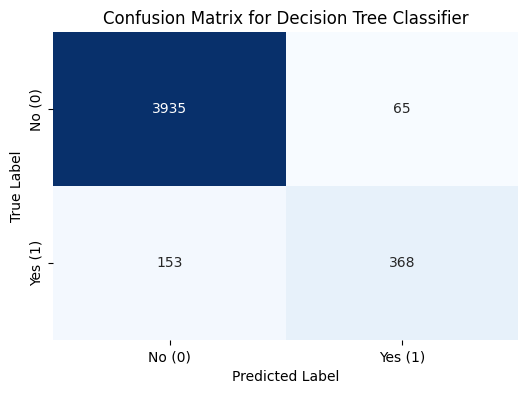

In [7]:
#Import Library for Confusion Metrix

from sklearn.metrics import confusion_matrix

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No (0)', 'Yes (1)'], yticklabels=['No (0)', 'Yes (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Decision Tree Classifier')
plt.show()

In [8]:
# Evaluate the model using the defined functions

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, classification_report, matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns


# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred_proba)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"AUC Score: {auc_score:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"MCC Score: {mcc:.4f}")

# Generate and print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Accuracy: 0.9518
AUC Score: 0.9767
Precision: 0.8499
Recall: 0.7063
F1-score: 0.7715
MCC Score: 0.7488

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      4000
           1       0.85      0.71      0.77       521

    accuracy                           0.95      4521
   macro avg       0.91      0.85      0.87      4521
weighted avg       0.95      0.95      0.95      4521

